# Interactive Learning Course
## HW #2, Multi-Armed Bandits

In [94]:
import numpy as np
from abc import ABC, abstractmethod
import gym
import matplotlib.pyplot as plt
from scipy.stats import norm

In [95]:
optimalQval = np.array([[-0.14, -10.425, -73.75],
                        [0.015, -2.125 , -15.5],
                        [-4.24, -0.8   , -0.6]])

# Part 2

## Reward class

In [96]:
class Reward(ABC):
    def __init__(self, debts=[5.0, 20.0, 100.0]):
        super(Reward, self).__init__()
        self.debts = debts
        
    @abstractmethod
    def get_reward(self, action):
        pass

In [97]:
class Student(Reward):
    def __init__(self):
        super(Student, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([4, 5, 5.1], p=[0.2, 0.2, 0.6])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.5, 0.3, 0.1, 0.1])
        else:
            obs = np.random.choice([10, 20, 50, 100, 105], p=[0.5, 0.3, 0.1, 0.05, 0.05])
        
        return obs, obs - self.debts[action]

In [98]:
class GovStaff(Reward):
    def __init__(self):
        super(GovStaff, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([4, 5, 5.1], p=[0.05, 0.3, 0.65])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.1, 0.1, 0.3, 0.5])
        else:
            obs = np.random.choice([20, 50, 80, 100, 105], p=[0.1, 0.1, 0.2, 0.3, 0.3])
        
        return obs, obs - self.debts[action]

In [99]:
class SelfEmp(Reward):
    def __init__(self):
        super(SelfEmp, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([0, 2.5, 5.1], p=[0.8, 0.1, 0.1])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.05, 0.05, 0.3, 0.6])
        else:
            obs = np.random.choice([20, 50, 80, 100, 105], p=[0.02, 0.03, 0.05, 0.2, 0.7])
        
        return obs, obs - self.debts[action]

## Environment

In [100]:
class Environment:
    def __init__(self, id = None):
        self.id = id
    
    def calc_reward(self, action):
        
        if self.id == 0:
            std = Student()
            obs, reward = std.get_reward(action)
            return reward

        elif self.id == 1:
            govStaff = GovStaff()
            obs, reward = govStaff.get_reward(action)
            return reward
        
        else:
            selfEmp = SelfEmp()
            obs, reward = selfEmp.get_reward(action)
            return reward
            
        

    def get_available_actions(self):
        return [0, 1, 2]

# Part 3

## Agent

In [101]:
class Agent(ABC):
    def __init__(self, id = None, env=Environment(), alpha=0, beta=1, gamma=1):
        self.env = env
        self.env.id = id
        self.id = id
        self.env = env
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.util = 0
        # self.rewards = [[ [], [], [] ]] *3


    @abstractmethod
    def choose_optimal_action(self): pass
        ## YOUR CODES ##
    
    def calculate_utility(self, reward):
        util = self.beta * reward**(self.gamma) + self.alpha
        return util
    
    @abstractmethod
    def take_action(self, action): pass
        ## YOUR CODES ##
    
    @abstractmethod
    def update_value(self, action, util): pass
    

    def step(self, best_reward, trial): pass
        ## YOUR CODES ##

    def reset(self): pass
        ## YOUR CODES ##
    
    def get_rewards(self): pass
        ## YOUR CODES ##
    
    def get_regrets(self): pass
        ## YOUR CODES ##

    @abstractmethod
    def run_one_trial(self, id, trialNum): pass

## Epsilon Greedy

In [102]:
class EGreedy(Agent):

    def __init__(self, epsilon, env = Environment(), id = None, alpha = 0, beta = 1, gamma = 1):
      super().__init__(id, env, alpha, beta, gamma)
      self.epsilon = epsilon
      self.Qvals = np.zeros((3, 3))
      self.actionCount = np.zeros((3, 3))

    def update_value(self, action):
      Q = self.Qvals[self.id, action]
      n = self.actionCount[self.id, action] + 1
      Q = Q + 1/n * (self.util - Q)
      self.Qvals[self.id, action] = Q
      self.actionCount[self.id, action] = n
      # self.rewards[self.id][action].append(util)

    def choose_optimal_action(self):
      actions = np.array([0, 1, 2])
      Qvals = self.Qvals[self.id]
      uniques = np.unique(Qvals)
      maxVal = np.max(uniques)
      indexes = Qvals == maxVal
      remainedActions = actions[indexes]
      optimalAction = np.random.choice(a = remainedActions)

      return optimalAction

    def take_action(self):
      optimalAction = self.choose_optimal_action()
      allActions = [optimalAction]
      for i in range(3):
        if i != optimalAction:
          allActions.append(i)
      

      chosenAction = np.random.choice(a = allActions, p = [1 - self.epsilon + self.epsilon/3, self.epsilon/3, self.epsilon/3])
      # print('chosenAction, OptimalAction =', chosenAction, optimalAction)    
      return chosenAction


    def update_epsilon(self):
      pass


    def run_one_trial(self, id, trialNum, update = True):
      self.id = id
      self.env.id = id
      action = self.take_action()
      reward = self.env.calc_reward(action)
      self.util = self.calculate_utility(reward)
      # print('reward =', reward)
      if update:
        self.update_value(action)
        self.update_epsilon()

    def reset(self):
        self.Qvals = np.zeros((3, 3))
        self.actionCount = np.zeros((3, 3))


In [103]:
epsilonInit = 1
eGreedy = EGreedy(epsilonInit)
trials = 30000
for t in range(1, trials + 1):
  id = int(t / 10000) % 3
  eGreedy.run_one_trial(id, t)

print(eGreedy.Qvals)

[[-1.41076830e-01 -1.04108926e+01 -7.35334907e+01]
 [ 1.55413625e-02 -2.14105201e+00 -1.55545482e+01]
 [-4.26868296e+00 -8.17335660e-01 -4.58515284e-01]]


## Upper Confidence Bound (UCB)

In [104]:
class UCB(Agent):

    def __init__(self, C, delta = 1, env = Environment(), id = None, alpha = 0, beta = 1, gamma = 1):
        super().__init__(id, env, alpha, beta, gamma)
        self.Qvals = np.zeros((3, 3))
        self.C = C
        self.delta = delta
        self.actionCount = np.zeros((3, 3))



    def update_value(self, action, util):
        Q = self.Qvals[self.id, action]
        n = self.actionCount[self.id, action] + 1
        Q = Q + 1/n * (util - Q)
        self.Qvals[self.id, action] = Q
        # self.rewards[self.id][action].append(util)
        self.actionCount[self.id, action] += 1

    def choose_optimal_action(self):
      actions = np.array([0, 1, 2])
      Qvals = self.Qvals[self.id]
      UCBs = [0] * 3
      
      for i in range(3):
        n = self.actionCount[self.id, i]
        if n == 0:
          UCBs[i] = 0
        else:
          UCBs[i] = Qvals[i] + self.C * np.sqrt(np.log10(1 / self.delta) / n)


      uniques = np.unique(UCBs)

      maxVal = np.max(uniques)
      indexes = UCBs == maxVal
      remainedActions = actions[indexes]
      optimalAction = np.random.choice(a = remainedActions)

      return optimalAction

    def take_action(self):
      optimalAction = self.choose_optimal_action()
      
      return optimalAction


    def calc_delta(self, trialNum):
      self.delta = 1 / trialNum


    def run_one_trial(self, id, trialNum, update = True):
      self.id = id
      self.env.id = id
      self.calc_delta(trialNum)
      action = self.take_action()
      reward = self.env.calc_reward(action)
      self.util = self.calculate_utility(reward)
      # print('reward =', reward)
      if update:
        self.update_value(action, self.util)

    def reset(self):
        self.Qvals = np.zeros((3, 3))
        self.actionCount = np.zeros((3, 3))


In [105]:
C = 200
ucb = UCB(C)
trials = 30000
for trial in range(trials):
  id = int(trial / 10000) % 3
  t = trial % 10000 + 1
  ucb.run_one_trial(id, t)


print(ucb.Qvals)

[[ -0.14089677 -10.46332737 -71.78571429]
 [  0.          -2.1498       0.        ]
 [ -4.25137026   0.          -0.1915559 ]]


## Gradient Based Algorithm

In [106]:
class GradientBased(Agent):

    def __init__(self, lr, env = Environment(), id = None, alpha = 0, beta = 1, gamma = 1):
        super().__init__(id, env, alpha, beta, gamma)
        self.Rhat =[0] * 3
        self.lr = lr
        self.count = [0] * 3
        self.H = np.zeros((3, 3))




    def update_value(self, action, util):
        policy = self.calc_policy()
        coeff = np.zeros((3))
        for i in range(3):
          if action == i:
            coeff[i] = 1 - policy[i]
          else:
            coeff[i] = -policy[i]
        

        self.H[self.id] = self.H[self.id] + self.lr * (util - self.Rhat[self.id])*coeff
        # print('util =', util, 'self.H[self.id] =', self.H[self.id], 'self.Rhat[self.id] =', self.Rhat[self.id], 'an =', self.lr * (util - self.Rhat[self.id])*coeff)
        # print('policy =', self.calc_policy())
        self.Rhat[self.id] = (self.Rhat[self.id] * (self.count[self.id] - 1) + util) / self.count[self.id]





    def calc_policy(self):
      pol = np.exp(self.H[self.id])
      sum = np.sum(pol)
      policy = pol / sum
      return policy

    def choose_optimal_action(self): pass


    def take_action(self):
      actions = [0, 1, 2]
      policy = self.calc_policy()
      # print(self.H[self.id].shape, policy.shape)


      # print(len(actions), (policy[0]), policy)
      chosenAction = np.random.choice(a = actions, p = policy)
      # print('self.coutn.shape, self.id =', self.count.shape, self.id, self.count[0, self.id])
      self.count[self.id] += 1
      # print('Policy =', policy, 'chosenAction =', chosenAction, 'self.count =', self.count[self.id], 'self.lr =', self.lr)

      return chosenAction


    def calc_learning_rate(self):
      # self.lr = 0.99 * self.lr
      pass


    def run_one_trial(self, id, trialNum, update= True):
      self.id = id
      self.env.id = id
      self.calc_learning_rate()
      action = self.take_action()
      reward = self.env.calc_reward(action)
      # print('reward =', reward)
      self.util = self.calculate_utility(reward)
      # print('reward =', reward)
      if update:
        self.update_value(action, self.util)

    def reset(self):
        self.Rhat =[0] * 3
        self.count = [0] * 3
        self.H = np.zeros((3, 3))



In [107]:
lr = 1e-2
gradientBased = GradientBased(lr)
trials = 3000
for trial in range(trials):
  # print('\n')
  # print('trial No.', trial)
  # id = 0
  id = int(trial / 1000) % 3
  t = trial % 1000 + 1
  gradientBased.run_one_trial(id, t)


print(gradientBased.H)

[[ 4.6743115  -1.10592077 -3.56839073]
 [ 3.72792549 -0.5667511  -3.16117439]
 [-2.1187614   0.34575119  1.7730102 ]]


#Part 4

In [108]:
epsilon = 0.2
C = 2
lr = 0.001

eGreedy = EGreedy(epsilon = epsilon)
ucb = UCB(C = C)
gradientBased = GradientBased(lr = lr)

studentRegret = -0.14
govStaffRegret = 0.015
selfEmpRegret = -0.6

trials = 100
episodes = 20

In [109]:
meanEGreedyRewardsStd = [0] * trials
meanUCBRewardsStd = [0] * trials
meanGradientRewardsStd = [0] * trials

eGreedy.reset()
ucb.reset()
gradientBased.reset()
update = True


#Students
id = 0
for trial in range(1, trials + 1): 
  eGreedyRews = [0] * episodes
  UCBRews = [0] * episodes
  gradientRews = [0] * episodes
  update = True
  for episode in range(episodes):
    eGreedy.run_one_trial(id, trial, update)
    ucb.run_one_trial(id, trial, update)
    gradientBased.run_one_trial(id, trial, update)

    eGreedyRews[episode] = eGreedy.util
    UCBRews[episode] = ucb.util
    gradientRews[episode] = gradientBased.util
    update = False

  meanEGreedyRewardsStd[trial - 1] = np.mean(eGreedyRews)
  meanUCBRewardsStd[trial - 1] = np.mean(UCBRews)
  meanGradientRewardsStd[trial - 1] = np.mean(gradientRews)


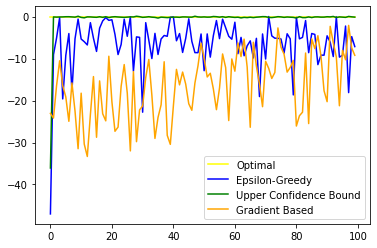

In [110]:
plt.plot([studentRegret] * 100, 'yellow')
plt.plot(meanEGreedyRewardsStd, 'blue')
plt.plot(meanUCBRewardsStd, 'green')
plt.plot(meanGradientRewardsStd, 'orange')
plt.legend(['Optimal', 'Epsilon-Greedy', 'Upper Confidence Bound', 'Gradient Based'])

In [111]:
meanEGreedyRewardsGovStaff = [0] * trials
meanUCBRewardsGovStaff = [0] * trials
meanGradientRewardsGovStaff = [0] * trials

eGreedy.reset()
ucb.reset()
gradientBased.reset()
update = True



#govStaff
id = 1
for trial in range(1, trials + 1):
  eGreedyRews = [0] * episodes
  UCBRews = [0] * episodes
  gradientRews = [0] * episodes
  update = True
  for episode in range(episodes):
    eGreedy.run_one_trial(id, trial, update)
    ucb.run_one_trial(id, trial, update)
    gradientBased.run_one_trial(id, trial, update)

    eGreedyRews[episode] = eGreedy.util
    UCBRews[episode] = ucb.util
    gradientRews[episode] = gradientBased.util

    update = False

  meanEGreedyRewardsGovStaff[trial - 1] = np.mean(eGreedyRews)
  meanUCBRewardsGovStaff[trial - 1] = np.mean(UCBRews)
  meanGradientRewardsGovStaff[trial - 1] = np.mean(gradientRews)


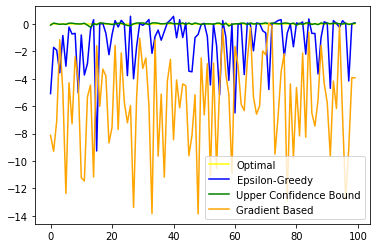

In [112]:
plt.plot([govStaffRegret] * 100, 'yellow')
plt.plot(meanEGreedyRewardsGovStaff, 'blue')
plt.plot(meanUCBRewardsGovStaff, 'green')
plt.plot(meanGradientRewardsGovStaff, 'orange')
plt.legend(['Optimal', 'Epsilon-Greedy', 'Upper Confidence Bound', 'Gradient Based'])

In [113]:
meanEGreedyRewardsSelfEmp = [0] * trials
meanUCBRewardsSelfEmp = [0] * trials
meanGradientRewardsSelfEmp = [0] * trials

eGreedy.reset()
ucb.reset()
gradientBased.reset()
update = True



#selfEmp
id = 2
for trial in range(1, trials + 1):
  eGreedyRews = [0] * episodes
  UCBRews = [0] * episodes
  gradientRews = [0] * episodes
  update = True
  for episode in range(episodes):
    eGreedy.run_one_trial(id, trial, update)
    ucb.run_one_trial(id, trial, update)
    gradientBased.run_one_trial(id, trial, update)

    eGreedyRews[episode] = eGreedy.util
    UCBRews[episode] = ucb.util
    gradientRews[episode] = gradientBased.util
    
    update = False

  meanEGreedyRewardsSelfEmp[trial - 1] = np.mean(eGreedyRews)
  meanUCBRewardsSelfEmp[trial - 1] = np.mean(UCBRews)
  meanGradientRewardsSelfEmp[trial - 1] = np.mean(gradientRews)


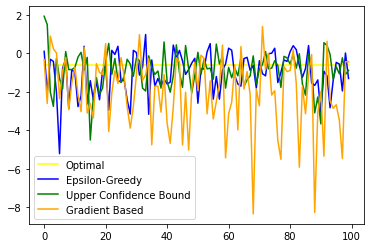

In [114]:
plt.plot([selfEmpRegret] * 100, 'yellow')
plt.plot(meanEGreedyRewardsSelfEmp, 'blue')
plt.plot(meanUCBRewardsSelfEmp, 'green')
plt.plot(meanGradientRewardsSelfEmp, 'orange')
plt.legend(['Optimal', 'Epsilon-Greedy', 'Upper Confidence Bound', 'Gradient Based'])

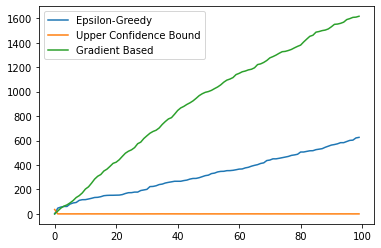

In [115]:
stdTrialRegretEGreedy = studentRegret - np.array(meanEGreedyRewardsStd)
stdRegretEGreedy = [np.sum(stdTrialRegretEGreedy[:i]) for i in range(trials)]

stdTrialRegretUCB = studentRegret - np.array(meanUCBRewardsStd)
stdRegretUCB = [np.sum(stdTrialRegretUCB[:i]) for i in range(trials)]

stdTrialRegretGradient = studentRegret - np.array(meanGradientRewardsStd)
stdRegretGradient = [np.sum(stdTrialRegretGradient[:i]) for i in range(trials)]


plt.plot(stdRegretEGreedy)
plt.plot(stdTrialRegretUCB)
plt.plot(stdRegretGradient)

plt.legend(['Epsilon-Greedy', 'Upper Confidence Bound', 'Gradient Based'])

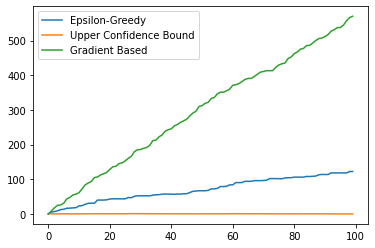

In [116]:
govStaffTrialRegretEGreedy = govStaffRegret - np.array(meanEGreedyRewardsGovStaff)
govStaffRegretEGreedy = [np.sum(govStaffTrialRegretEGreedy[:i]) for i in range(trials)]

govStaffTrialRegretUCB = govStaffRegret - np.array(meanUCBRewardsGovStaff)
govStaffRegretUCB = [np.sum(govStaffTrialRegretUCB[:i]) for i in range(trials)]

govStaffTrialRegretGradient = govStaffRegret - np.array(meanGradientRewardsGovStaff)
govStaffRegretGradient = [np.sum(govStaffTrialRegretGradient[:i]) for i in range(trials)]


plt.plot(govStaffRegretEGreedy)
plt.plot(govStaffRegretUCB)
plt.plot(govStaffRegretGradient)

plt.legend(['Epsilon-Greedy', 'Upper Confidence Bound', 'Gradient Based'])

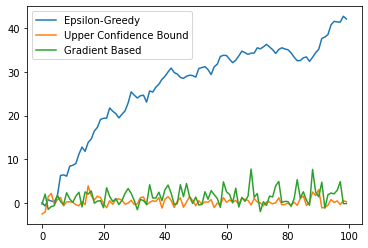

In [117]:
selfEmpTrialRegretEGreedy = selfEmpRegret - np.array(meanEGreedyRewardsSelfEmp)
selfEmpRegretEGreedy = [np.sum(selfEmpTrialRegretEGreedy[:i]) for i in range(trials)]

selfEmpTrialRegretUCB = selfEmpRegret - np.array(meanUCBRewardsSelfEmp)
selfEmpRegretUCB = [np.sum(selfEmpTrialRegretUCB[:i]) for i in range(trials)]

selfEmpTrialRegretGradient = selfEmpRegret - np.array(meanGradientRewardsSelfEmp)
selfEmpRegretGradient = [np.sum(selfEmpTrialRegretGradient[:i]) for i in range(trials)]


plt.plot(selfEmpRegretEGreedy)
plt.plot(selfEmpTrialRegretUCB)
plt.plot(selfEmpTrialRegretGradient)

plt.legend(['Epsilon-Greedy', 'Upper Confidence Bound', 'Gradient Based'])

# Part 5

In [118]:
learning_rates = [1, 0.1, 0.001, 0.0001]
trials = 20

meanGradientRewardsStd = [0] * trials
meanGradientRewardsGovStaff = [0] * trials
meanGradientRewardsSelfEmp = [0] * trials

In [119]:
#Students
avgStdReg = {}
avgStdRew = {}
update = True
for lr in learning_rates:
  gradientBased = GradientBased(lr = lr)
  avgStdRew[str(lr)] = []
  for trial in range(1, trials + 1):
    gradientRews = [0] * episodes
    update = True
    for episode in range(episodes):
      gradientBased.run_one_trial(id, trial, update)
      gradientRews[episode] = gradientBased.util
      update = False

    avgStdRew[str(lr)].append(np.mean(gradientRews))
  stdReg = studentRegret - np.array(avgStdRew[str(lr)])
  avgStdReg[str(lr)] = [np.sum(stdReg[:i]) for i in range(trials)]

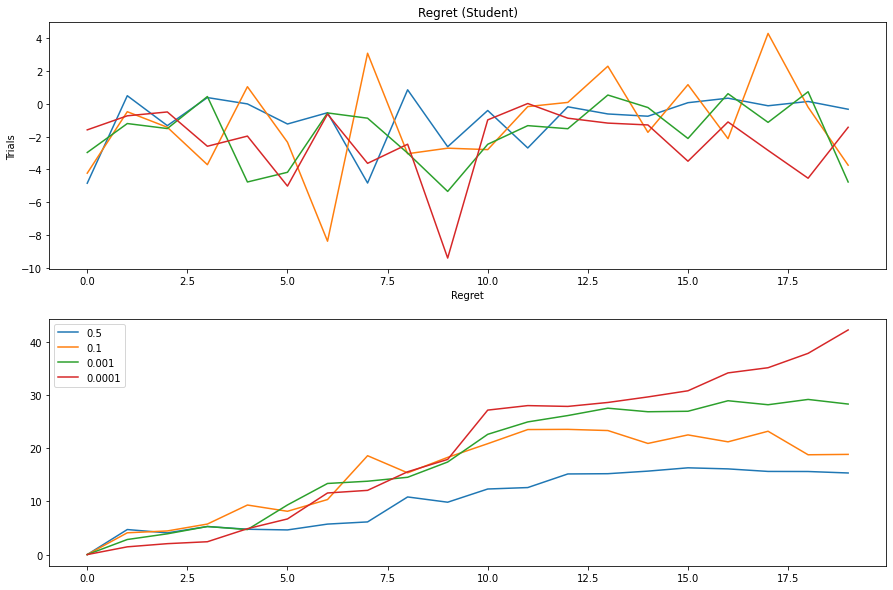

In [120]:
fig, axes = plt.subplots(2, 1, figsize = (15, 10))
for i, lr in enumerate(learning_rates):
  axes[0].set_title('Average Reward (Student)'.format(trials))
  axes[0].set_xlabel('Avg Reward')
  axes[0].set_ylabel('Trials')
  axes[0].plot(avgStdRew[str(lr)])

  axes[0].set_title('Regret (Student)'.format(trials))
  axes[0].set_xlabel('Regret')
  axes[0].set_ylabel('Trials')
  axes[1].plot(avgStdReg[str(lr)])

plt.legend(['0.5', '0.1', '0.001', '0.0001'])

In [121]:
#Government Staff
avgGovStaffReg = {}
avgGovStaffRew = {}
update = True
for lr in learning_rates:
  gradientBased = GradientBased(lr = lr)
  avgGovStaffRew[str(lr)] = []
  for trial in range(1, trials + 1):
    gradientRews = [0] * episodes
    update = True
    for episode in range(episodes):
      gradientBased.run_one_trial(id, trial, update)
      gradientRews[episode] = gradientBased.util
      update = False

    avgGovStaffRew[str(lr)].append(np.mean(gradientRews))
  govStaffReg = govStaffRegret - np.array(avgGovStaffRew[str(lr)])
  avgGovStaffReg[str(lr)] = [np.sum(govStaffReg[:i]) for i in range(trials)]

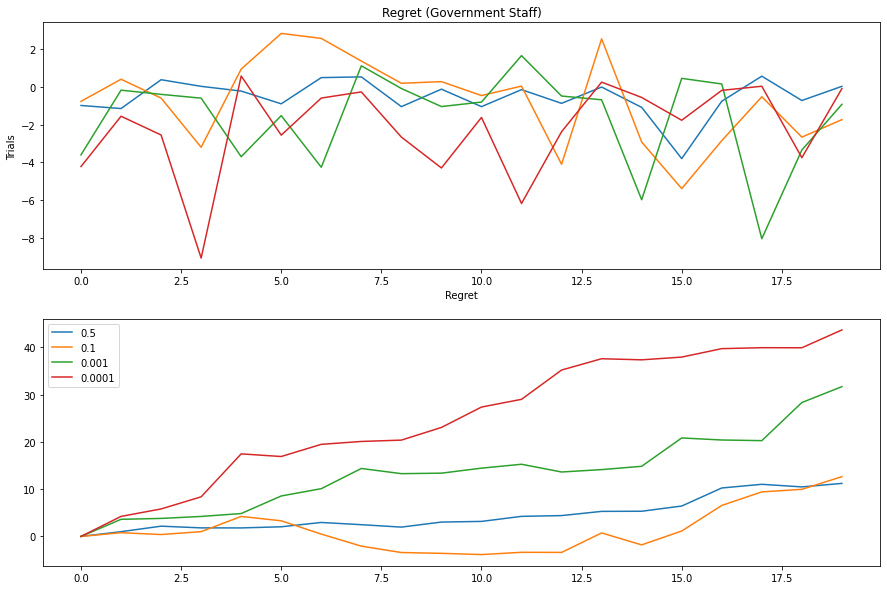

In [122]:
fig, axes = plt.subplots(2, 1, figsize = (15, 10))
for i, lr in enumerate(learning_rates):
  axes[0].set_title('Average Reward (Govertment Staff)'.format(trials))
  axes[0].set_xlabel('Avg Reward')
  axes[0].set_ylabel('Trials')
  axes[0].plot(avgGovStaffRew[str(lr)])

  axes[0].set_title('Regret (Government Staff)'.format(trials))
  axes[0].set_xlabel('Regret')
  axes[0].set_ylabel('Trials')
  axes[1].plot(avgGovStaffReg[str(lr)])

plt.legend(['0.5', '0.1', '0.001', '0.0001'])

In [123]:
#Self Employed
avgSelfEmpReg = {}
avgSelfEmpRew = {}
update = True
for lr in learning_rates:
  gradientBased = GradientBased(lr = lr)
  avgSelfEmpRew[str(lr)] = []
  for trial in range(1, trials + 1):
    gradientRews = [0] * episodes
    update = True
    for episode in range(episodes):
      gradientBased.run_one_trial(id, trial, update)
      gradientRews[episode] = gradientBased.util
      update = False

    avgSelfEmpRew[str(lr)].append(np.mean(gradientRews))
  selfEmpReg = selfEmpRegret - np.array(avgSelfEmpRew[str(lr)])
  avgSelfEmpReg[str(lr)] = [np.sum(selfEmpReg[:i]) for i in range(trials)]

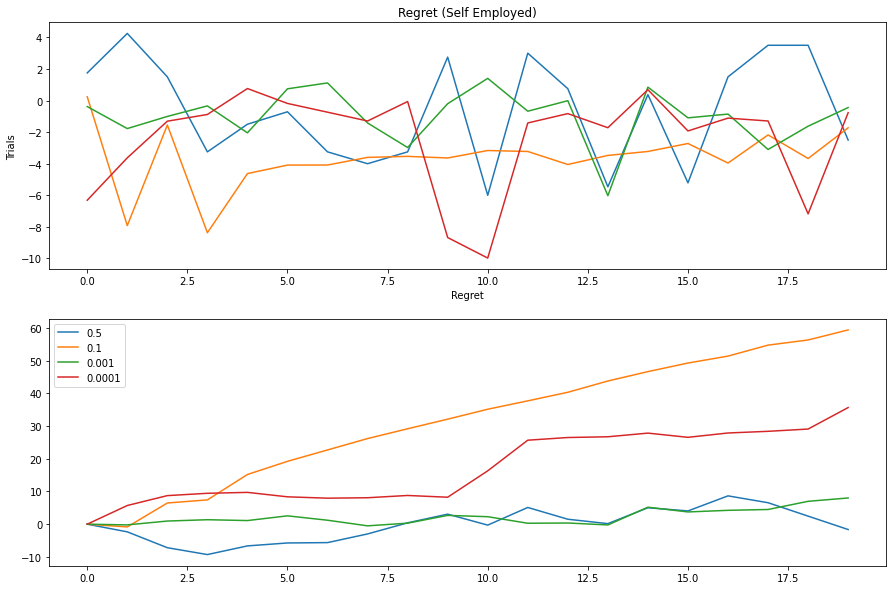

In [124]:
fig, axes = plt.subplots(2, 1, figsize = (15, 10))
for i, lr in enumerate(learning_rates):
  axes[0].set_title('Average Reward (Self Employed)'.format(trials))
  axes[0].set_xlabel('Avg Reward')
  axes[0].set_ylabel('Trials')
  axes[0].plot(avgSelfEmpRew[str(lr)])

  axes[0].set_title('Regret (Self Employed)'.format(trials))
  axes[0].set_xlabel('Regret')
  axes[0].set_ylabel('Trials')
  axes[1].plot(avgSelfEmpReg[str(lr)])

plt.legend(['0.5', '0.1', '0.001', '0.0001'])